In [29]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from ast import literal_eval
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
import itertools
import tensorflow_datasets as tfds
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from IPython.display import Image
from wordcloud import WordCloud,STOPWORDS
import inspect
from bayes_opt import BayesianOptimization
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,accuracy_score
from scipy.interpolate import griddata
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

In [157]:
path = 'learn-ai-bbc'
train = pd.read_csv(path+'/BBC News Train.csv')
test = pd.read_csv(path+'/BBC News Test.csv')


In [ ]:
table=[]
table.append(['Method',"Train Accuracy", 'Test Accuracy'])

<center> <BIG><big>
<big>
<BIG><BIG><BIG><B> EXPLORATORY DATA ANALYSIS

<BIG><b><big>
<big>
 First let us load dataframe.info to get the size of the dataframe

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


<BIG> <b><big>
<big>
 Now let us check number of categories

In [32]:
train['Category'].nunique() 

5

<BIG><b><big>
<big>
Let us see the total duplicate titles and examine deduplicated dataset through histogram

In [158]:
total_duplicate_titles = sum(train["Text"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")
train = train[~train["Text"].duplicated()]


There are 50 duplicate titles.


(array([335.,   0., 234.,   0.,   0., 266.,   0., 342.,   0., 263.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

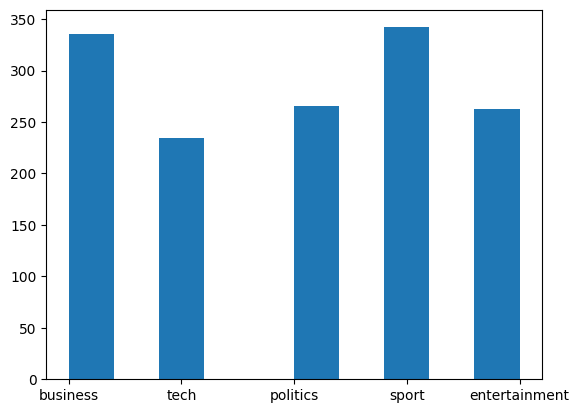

In [34]:
plt.hist(train['Category'])

In [35]:
train["Text"].apply(lambda x: len(x.split())).describe()


count    1440.000000
mean      385.215972
std       212.167106
min        90.000000
25%       253.000000
50%       337.000000
75%       468.250000
max      3345.000000
Name: Text, dtype: float64

<big>
<big>

<BIG> Now let us make a function to check permutations of label order to get the right clusters

<big>

In [36]:
## PERMUTATION CHECK Function as used in week 2
pd.set_option('future.no_silent_downcasting', True)
def permute_label(yp,label):

    k = list(train['Category'].unique())
    n = list(range(5))
    acc_cop = 0
    for i in itertools.permutations(n):
        d = dict(zip(k,i))
        l =  list(label.astype(str).replace(d,inplace=False))
        acc = sklearn.metrics.accuracy_score(l,yp )
        if acc_cop< acc:
            acc_cop = acc
            final_labels_order = i
    #print(f"accuracy : {acc_cop}")
    #print(f"final_labels : {final_labels_order}")
    return acc_cop,final_labels_order


<BIG> <big>
<big>
WordCloud is a tool to see the frequencies of words. Lets try this first without stopwords which means common english words like 'him, she' etc.  are not to be used. 

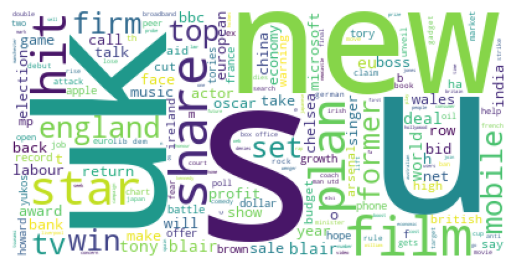

In [37]:
wc = WordCloud(background_color = "white",max_words =300).generate(train.Text.to_string())
plt.imshow(wc)
plt.axis("off")
plt.show()

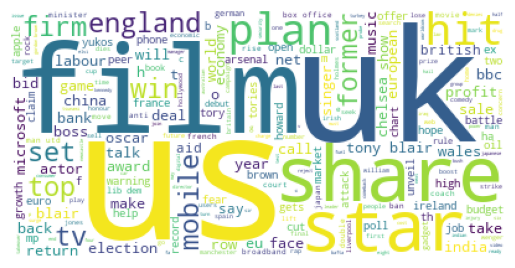

In [38]:
wc = WordCloud(background_color = "white",max_words =300,stopwords=['s','u','new']+list(STOPWORDS)).generate(train.Text.to_string())
plt.imshow(wc)
plt.axis("off")
plt.show()

<BIG><big>
<big>
 Use tf-idf vectorization from sklearn. tfidf uses word counts as a measure to sort words. It also uses idf frequency to rank word
importance, since every word may not be unique/important. Max_df is 0.5 which means word appearing in more than 50% of the documents will be disregarded.
min_df is an integer, i.e., 20 which implies that words appearing in less than 20 documents will also be disregarded. Stop_words is 'english'. This method can help us classify the documents via tf, idf values. Similar documents will have similar words, i.e., tf,idf will be corresponding for those words in these documents.

In [39]:
# Use tf-idf features.
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=20,
     stop_words = 'english'
)
tfidf = tfidf_vectorizer.fit_transform(train.Text)


<center> <BIG><BIG><BIG><BIG><B><big>
<big>
 UNSUPERVISED LEARNING

<BIG> <big>
<big>
We will only use train data to find the correct label order. We will also do hyperparameter tuning to find the best combination of linkage and distance metric. Later both test and train data will be used as a concatenated series as this is unsupervised learning and there are no labels and thus fitting not being label-based there are no chances of overfitting, and we can do it to increase the data samples.

In [40]:
tfidf = tfidf_vectorizer.fit_transform(train.Text)
print('linkage','affinity','accuracy','final label')
l=[]
for linkage in ['ward', 'complete', 'average', 'single']:
    for affinity in ["euclidean", 'l1', 'l2', 'manhattan', 'cosine', 'precomputed']:
        try:
            model = AgglomerativeClustering(n_clusters = 5,linkage = linkage, metric = affinity,  )
            yp = model.fit(tfidf.toarray()).labels_
            ac, final_labels = permute_label(yp,train.Category)
            l.append([linkage,affinity,ac,final_labels,yp,model])
        except:
            pass
print(sorted(l,key=lambda x: x[2])[-1][:4])


linkage affinity accuracy final label
['ward', 'euclidean', 0.8756944444444444, (3, 4, 1, 0, 2)]


<BIG> <big>
<big>
 Final label is used to calculate the test result. We also append the test dataset to retrain the model.

In [41]:
tfidf = tfidf_vectorizer.fit_transform(pd.concat([train['Text'],test['Text']]))
l  = (sorted(l,key=lambda x: x[2])[-1][-1]).fit_predict(tfidf.toarray()).astype(str)

In [42]:
c=0
for i in final_labels:
    l[l==str(i)] = train.Category.unique()[c]
    c+=1

In [43]:
test['Category'] = l[1440:]
test[['ArticleId','Category']].to_csv('Solution_Agglomerative.csv',index=False)
!kaggle competitions submit -c learn-ai-bbc -f Solution_Agglomerative.csv -m "Message"

100%|██████████████████████████████████████| 9.13k/9.13k [00:01<00:00, 8.91kB/s]
Successfully submitted to BBC News Classification

<b><center> <Big>TEST SET RESULT only with TRAIN DATA



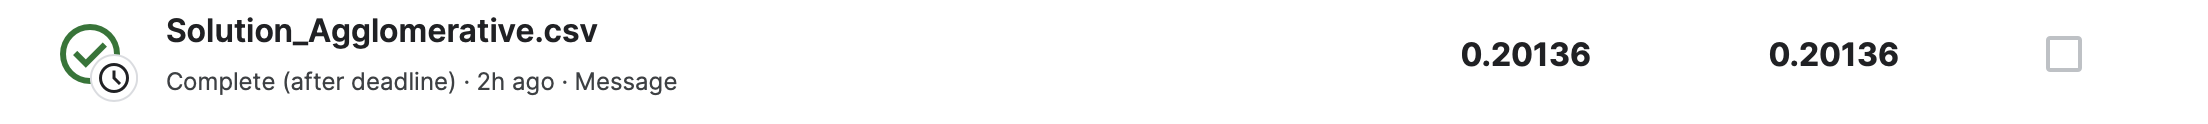

In [44]:
Image('Desktop/Screenshot 2024-05-15 at 5.41.08 AM.png')

<b><center><BIG> TEST SET RESULT with TEST DATA


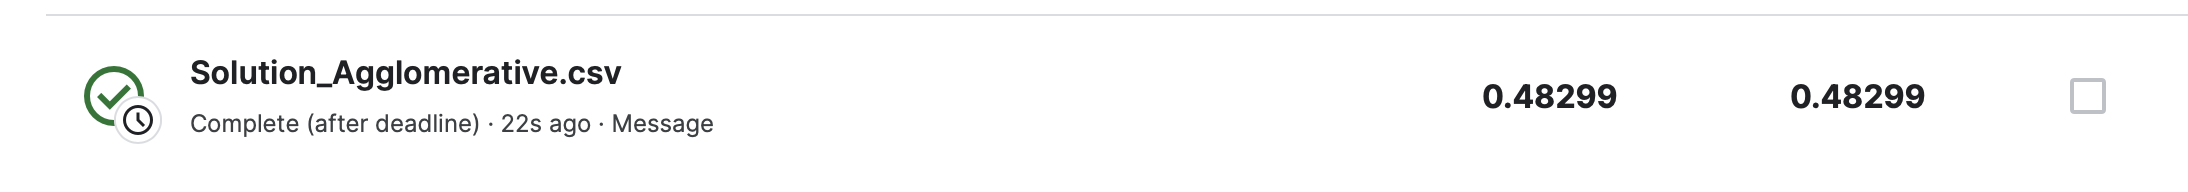

In [45]:
Image("Desktop/Screenshot 2024-05-15 at 7.46.20 AM.png")

In [46]:
table.append(['Hierarchial Clustering',0.88,0.48])

<BIG><big>
<big>
 The result on train set is good. The test set result is average.

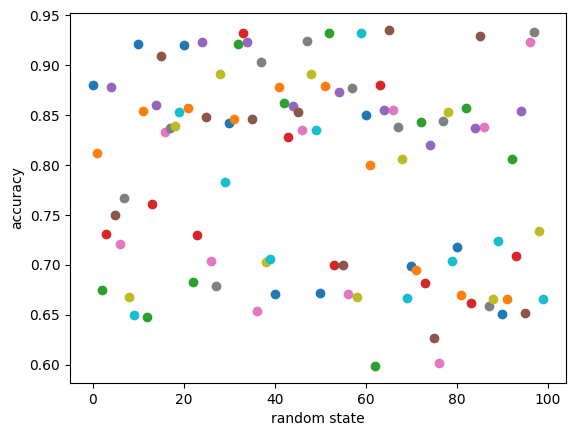

accuracy 0.9354166666666667
final_labels (2, 3, 1, 4, 0)


In [47]:
##MODEL KMEANS
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=20,
    stop_words="english",
    max_features = 1000
)
tfidf = tfidf_vectorizer.fit_transform(train['Text'])
l = []
for i in range(100):
    model = KMeans(n_clusters = 5, random_state = i).fit(tfidf)
    label_model = model.labels_
    
    label = train['Category']
    acc, final_labels = permute_label(label_model,label)
    plt.scatter(i,acc)
    l.append([acc,final_labels,model])
plt.xlabel('random state')
plt.ylabel('accuracy')
plt.show()
acc,final_labels,model = sorted(l, key = lambda x:x[0])[-1]
print(f"accuracy",acc)
print(f"final_labels",final_labels)

<BIG><big>
<big>
 We change the random state as the Kmeans method is giving different results every time. Then we store the best model. The result on the train set is good. The final label is used to calculate the test set result as above and gives us much better result than hierarchial clustering

In [48]:
tfidf = tfidf_vectorizer.fit_transform(pd.concat([train['Text'],test['Text']]))
l = model.predict(tfidf.toarray()).astype(str)
c=0
for i in final_labels:
    l[l==str(i)] = train.Category.unique()[c]
    c+=1
test['Category'] = l[1440:]
test[['ArticleId','Category']].to_csv('Solution_kMeans.csv',index=False)
!kaggle competitions submit -c learn-ai-bbc -f Solution_kMeans.csv -m "Message"

100%|██████████████████████████████████████| 8.96k/8.96k [00:01<00:00, 8.95kB/s]
Successfully submitted to BBC News Classification

<b><center> <Big>TEST SET RESULT


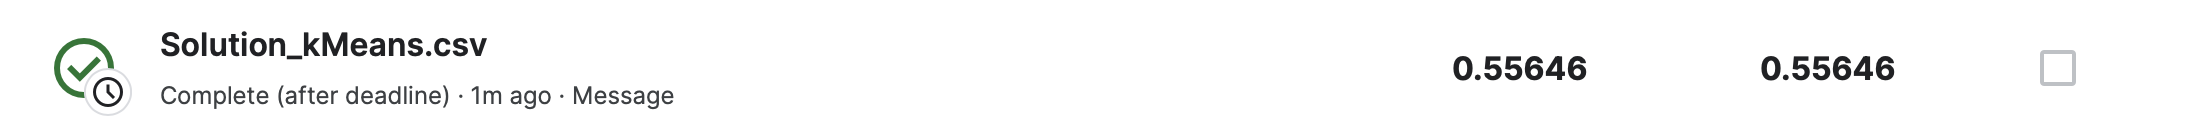

In [49]:
Image( "Desktop/Screenshot 2024-05-15 at 8.07.10 AM.png")

<BIG><big>
<big>
 Both the unsupervised learning methods are similar in performance but Kmeans beats Hierarchial Clustering

<BIG><center><b>Summary of results

In [50]:
table.append(['KMeans',0.94,0.55])

In [51]:
pd.DataFrame(table[1:],columns=table[0][:]).set_index('Method')

,Train Accuracy,Test Accuracy
Method,,
Hierarchial Clustering,0.88,0.48
KMeans,0.94,0.55


<BIG><BIG><big><BIG><BIG><big> <b> <center>MATRIX FACTORIZATION

<BIG><BIG><BIG><BIG>We will use non negative matrix factorization to to get 5 components corresponsing to 5 categories in the data. These components
will be classified based on their weights for each document, i.e. the weight with the highest value for 
each document will be the category of the 
document. Both train and test data will be utilized after finding the correct label order, i.e., the one which matches the ground truth, through label_permute function.

In [52]:
def label_permute_2(yp,Categ):
    l =[]
    for i in itertools.permutations(train["Category"].unique()):
        lookup = tf.keras.layers.StringLookup(vocabulary = i,output_mode="one_hot",num_oov_indices = 0)
        label_mh = [lookup(label).numpy() for label in Categ]
        l.append([sklearn.metrics.accuracy_score(yp,label_mh),i])
    return sorted(l,key = lambda x : x[0])[-1]
    
def nmf_opt(tfidf_vectorizer, df1=None, Train=False):
    """
    Parameters: 
    tfidf_vectorizer is the tfidf feature vector
    df1 is the test set  when train = false 
    and is none when train = True

    Return acc, label when train = true
    matrix W when df1 = Test
    """
    tfidf = tfidf_vectorizer.fit_transform(df1['Text'])
    C = csr_matrix(tfidf)
    X = sklearn.decomposition.NMF(n_components=5,solver='mu',init = 'nndsvda',
                                   beta_loss="kullback-leibler",alpha_W=0.00005,alpha_H=0.00005,
                                  l1_ratio=0.5,random_state =4, max_iter =500).fit(C)
    W = (X.transform(C))
    W = np.array([W[i]==max(W[i]) for i in range(len(df1))]) ##Since every word vector is now divided into its weights for each catergory
    #we decide to take the maximum strength for each sample and set that to 1 and rest to zero. Hence the strengthiest weight
    #becomes the category.
    if Train :
        out = label_permute_2(W,df1.Category.values)
    else:    
        out = W
    return out

label :(0.9520833333333333, ('business', 'politics', 'sport', 'entertainment', 'tech'))
acc ; 0.9520833333333333


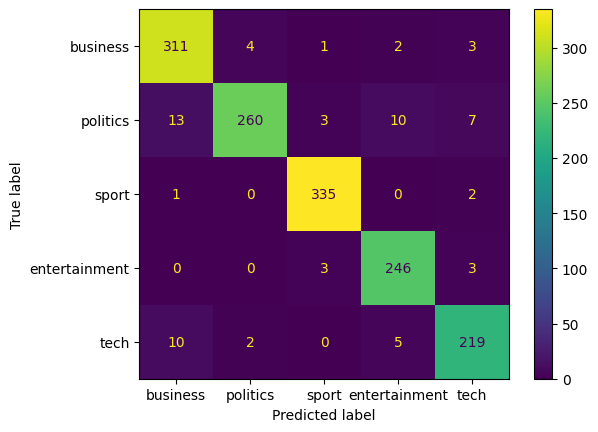

In [53]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=20, 
    stop_words="english",
    max_features=1000)
acc, label_order = nmf_opt(tfidf_vectorizer,df1 = train, Train = True)
print(f"label :{acc,label_order}")
result = nmf_opt(tfidf_vectorizer,df1 = train)
arr_res = np.array([result[i]==max(result[i]) for i in range(len(result))]).astype(int)
yp = [np.take(label_order,np.argwhere(arr_res[i] == 1.0)[..., 0])[0] for i in range(len(result))]
print(f"acc ; {accuracy_score(yp[:1440],list(train.Category))}")
ConfusionMatrixDisplay(confusion_matrix(yp[:1440],list(train.Category),labels = label_order ),display_labels = label_order).plot()
plt.show()


<BIG>So this is a fair enough result. Let us now try hyperparameter optimization for the tfidf word processing algorithm.

In [71]:
l = []

pbounds = {'max_df' :(0.1,1),'min_df' : (1,100),}
## Find best parameters
def bb_function(max_df,min_df):
    tfidf_vectorizer = TfidfVectorizer(
    max_df=int(max_df*100)/100.,
    min_df=int(min_df), 
    stop_words="english",
    max_features=1000
    )
    result = nmf_opt(tfidf_vectorizer,df1 = train)
    arr_res = np.array([result[i]==max(result[i]) for i in range(len(result))]).astype(int)
    yp = [np.take(label_order,np.argwhere(arr_res[i] == 1.0)[..., 0])[0] for i in range(len(result))]
    acc = accuracy_score(yp[:1440],list(train.Category))
    return acc
optimizer = BayesianOptimization(f = bb_function,pbounds = pbounds,random_state = 1)
# logger = JSONLogger(path="./logs.log")
# optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.maximize(
    init_points=100,
    n_iter=1000,
)
print('')

In [73]:
load_logs(optimizer, logs=["logs.log.json"]);
dic = optimizer.max['params']
print(int(dic['max_df']*100)/100.)

0.24
1100


In [74]:
dic = optimizer.max['params']


accuracy:0.9541666666666667


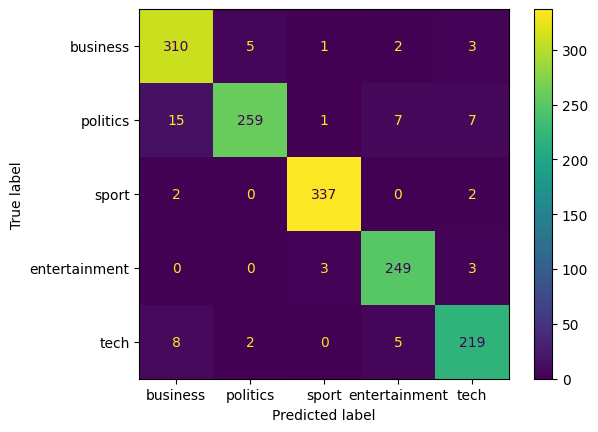

In [76]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=dic['max_df'],
    min_df=int(dic['min_df']), 
    stop_words="english",
    max_features=1000,
    )
result = nmf_opt(tfidf_vectorizer,df1 = train)
arr_res = np.array([result[i]==max(result[i]) for i in range(len(result))]).astype(int)
yp = [np.take(label_order,np.argwhere(arr_res[i] == 1.0)[..., 0])[0] for i in range(len(result))]

ConfusionMatrixDisplay(confusion_matrix(yp,list(train.Category),labels = label_order ),display_labels = label_order).plot()
print(f"accuracy:{accuracy_score(yp,list(train.Category))}")
plt.show()


In [77]:
l=[]
a = ['target','params']
b = [[item[i]for item in optimizer.res]for i in a]
l = np.array([[k for j,k in i.items()] for i in b[1]])

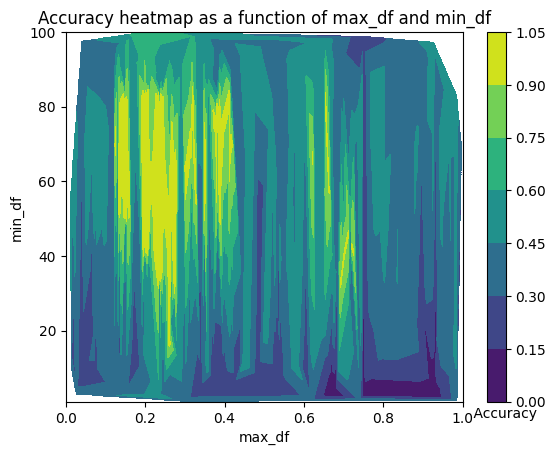

In [124]:
x,y = np.linspace(0.1,1,1000),np.linspace(1,100,1000)
x,y = np.meshgrid(x,y)
g = griddata(points = (l[:,0],l[:,1]), values = b[0], xi = (x,y),method = 'linear')
plt.contourf(np.linspace(0,1,1000),np.linspace(1,100,1000),g.T)
plt.xlabel('max_df')
plt.ylabel('min_df')
plt.title('Accuracy heatmap as a function of max_df and min_df')
cb = plt.colorbar()
cb.ax.set_xlabel('    Accuracy')
plt.show()

In [130]:
## Check Test set
tfidf_vectorizer = TfidfVectorizer(
    max_df= int(dic['max_df']*100)/100,
    min_df=int(dic['min_df']),
    stop_words="english",
    max_features=1000)
result = nmf_opt(tfidf_vectorizer,df1 = pd.concat([train,test]))
arr_res = np.array([result[i]==max(result[i]) for i in range(len(result))]).astype(int)
yp = [np.take(label_order,np.argwhere(arr_res[i] == 1.0)[..., 0])[0] for i in range(len(result))]
test['Category'] = yp[1440:]
test[['ArticleId','Category']].to_csv('Solution_NMF.csv',index=False)
!kaggle competitions submit -c learn-ai-bbc -f Solution_NMF.csv -m "Message"

100%|██████████████████████████████████████| 9.25k/9.25k [00:01<00:00, 8.71kB/s]
Successfully submitted to BBC News Classification

<b>  <center> <Big>  TEST SET RESULT



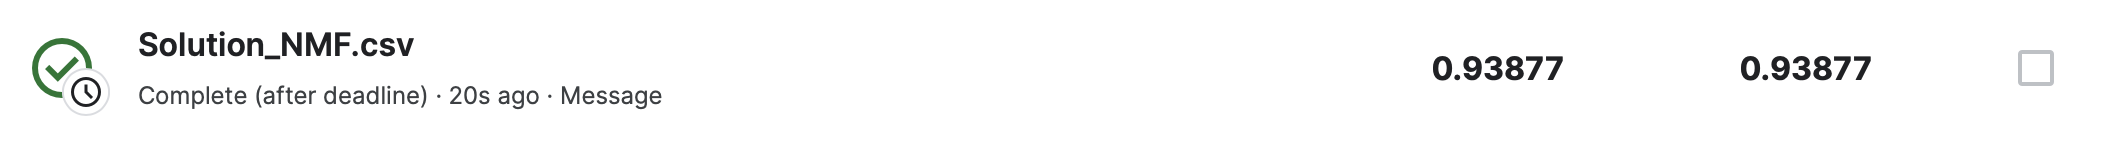

In [131]:
Image( "Desktop/Screenshot 2024-05-28 at 11.38.13 AM.png")

In [132]:
table.append(['NMF',0.96,0.94])

In [133]:
pd.DataFrame(table[1:],columns=table[0][:]).set_index('Method')

,Train Accuracy,Test Accuracy
Method,,
Hierarchial Clustering,0.88,0.48
KMeans,0.94,0.55
NMF,0.96,0.94


<BIG> <big>
<big>
I am happy with this score. 
To improve let us use another feature extraction method such as Word2Vec which uses word embedding to convert text
into word vectors. From EDA we saw that max length is 3345

In [134]:
word2vec = tf.keras.layers.TextVectorization(
    max_tokens=3345,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    encoding='utf-8',
)

In [140]:
def label_permute_2(yp,Categ):
    l =[]
    for i in itertools.permutations(train["Category"].unique()):
        lookup = tf.keras.layers.StringLookup(vocabulary = i,output_mode="one_hot",num_oov_indices = 0)
        label_mh = [lookup(label).numpy() for label in Categ]
        l.append([sklearn.metrics.accuracy_score(yp,label_mh),i])
    return sorted(l,key = lambda x : x[0])[-1]
    

def nmf_opt(word2vec,df1=None,Train=False):
    ## NMF optimizer function 

    """
    Parameters: 
    tfidf_vectorizer is the tfidf feature vector
    df1 is the test set  when train = false 
    and is none when train = True

    Return acc, label when train = true
    matrix W when df1 = Test
    """
    word2vec.adapt(df1.Text)
    word2vec_df = word2vec(df1.Text)
    C = csr_matrix(word2vec_df)
    X = sklearn.decomposition.NMF(n_components=5,solver='mu',init = 'nndsvda',
                                   beta_loss="kullback-leibler",alpha_W=0.00005,alpha_H=0.00005,
                                  l1_ratio=0.5,random_state =4).fit(C)
    W = (X.transform(C))
    W = np.array([W[i]==max(W[i]) for i in range(len(df1))])
    if Train :
        out = label_permute_2(W,train['Category'].values)
    else:    
        out = W
    return out



In [179]:

def remove_stopwords_word2vec_only(st):
    st = st.lower().split()
    m = [i for i in st if i not in STOPWORDS]
    return str(m)
train_w2v = train.copy()
train_w2v.Text = train.Text.apply(lambda x: remove_stopwords_word2vec_only(x))

In [180]:
## Find best parameters
word2vec = tf.keras.layers.TextVectorization(
max_tokens=3345,
standardize='lower_and_strip_punctuation',
split='whitespace',
output_mode='int',
output_sequence_length=None,
pad_to_max_tokens=False,
encoding='utf-8',
)
acc, label_order = nmf_opt(word2vec,df1=train_w2v,Train=True) 
result = nmf_opt(word2vec,df1 = train_w2v)
arr_res = np.array([result[i]==max(result[i]) for i in range(len(result))]).astype(int)
yp = [np.take(label_order,np.argwhere(arr_res[i] == 1.0)[..., 0])[0] for i in range(len(result))]

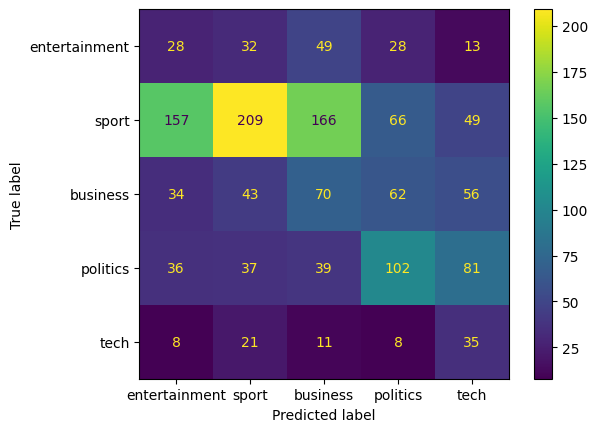

In [181]:
ConfusionMatrixDisplay(confusion_matrix(yp,list(train.Category),labels = label_order ),display_labels = label_order).plot()

In [182]:
print(F"Train set -- accuracy, {acc}")
print(F"Label order -- :{label_order}")

Train set -- accuracy, 0.30833333333333335
Label order -- :('entertainment', 'sport', 'business', 'politics', 'tech')


<BIG><big>
<big>
The accuracy is bad using this method. The label order is also wrong which we know from previous results. However, the mismatching is too bad to help.

<BIG><BIG><BIG> <center><b><BIG><big>
<big>
SUPERVISED LEARNING

In [189]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score

max acc, neighbors [1.0, 1]


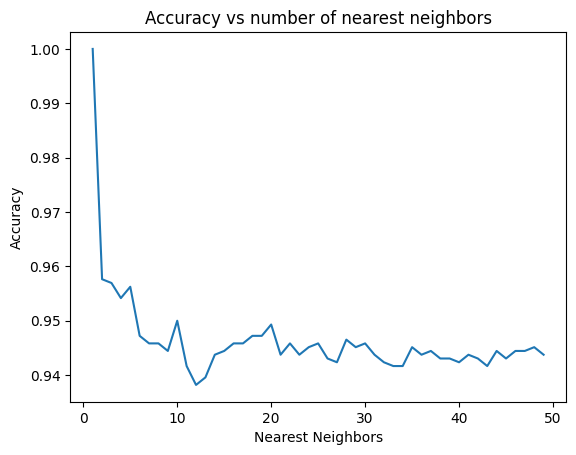

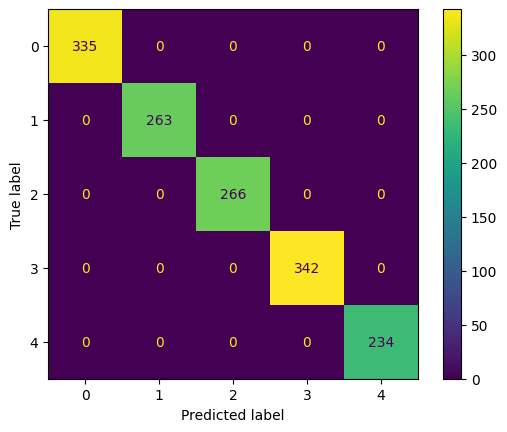

 acc, split [0.875, 0.1]
 acc, split [0.9236111111111112, 0.30000000000000004]
 acc, split [0.9451388888888889, 0.5]
 acc, split [0.9659722222222222, 0.7000000000000001]
 acc, split [0.9888888888888889, 0.9]


In [212]:
##use KNN on the data
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=20,
    stop_words="english",
    max_features = 1000
)
tfidf = tfidf_vectorizer.fit_transform(train['Text'])
tfidf_test = tfidf_vectorizer.fit_transform(test['Text'])
##Check best value of number of nearest neighbors
l=[]
m=[]
for i in range(1,50):
    
    l.append([accuracy_score(sklearn.neighbors.KNeighborsClassifier(
        n_neighbors = i).fit(tfidf,train.Category).predict(tfidf),train.Category),i])
    m.append(accuracy_score(sklearn.neighbors.KNeighborsClassifier(
        n_neighbors = i).fit(tfidf,train.Category).predict(tfidf),train.Category))
print("max acc, neighbors" , (sorted(l,key =lambda x: x[0]))[-1])
nn = (sorted(l,key =lambda x: x[0]))[-1][1]
##Train splitting accuracy check
plt.plot(range(1,50),m)
plt.xlabel('Nearest Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs number of nearest neighbors')
y_pred = (sklearn.neighbors.KNeighborsClassifier(
        n_neighbors = nn).fit(tfidf,train.Category).predict(tfidf))
ConfusionMatrixDisplay(confusion_matrix(y_pred,list(train.Category))).plot()
plt.show()
for i in np.arange(1,11,2)*0.1:
    model = sklearn.neighbors.KNeighborsClassifier(
        n_neighbors = nn).fit(*sklearn.utils.shuffle(tfidf,train.Category,random_state =1 ,n_samples=int(1440*i)))
    l = ([model.score(tfidf,train.Category),(i)])
    print(" acc, split" , l)
test['Category']= sklearn.neighbors.KNeighborsClassifier(n_neighbors = nn).fit(tfidf,train.Category).predict(tfidf_test)
test[['ArticleId','Category']].to_csv('Solution_KNN.csv',index=False)

<b> <center> <Big> TEST SET RESULT


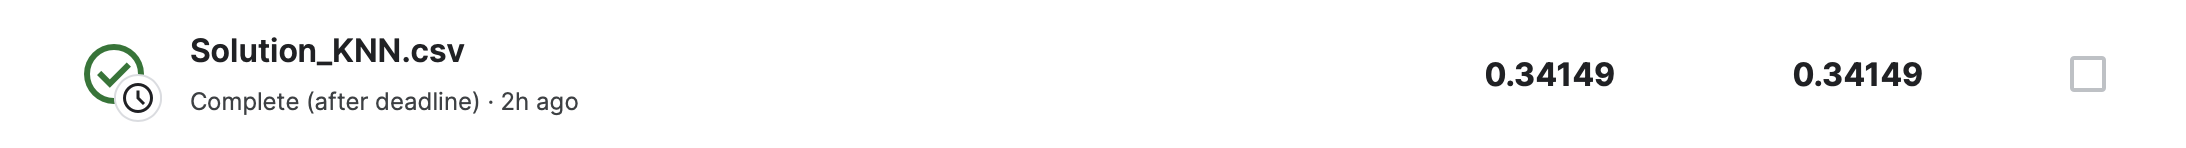

In [266]:
Image("Desktop/Screenshot 2024-05-15 at 5.32.37 AM.png")

In [184]:
table.append(['KNN',1.0,0.34])

<BIG> <big>
<big>
50% data gives 95% accuracy on train set. The train set accuracy is 100. The test set result is little lesser to the 2 typical unsupervised learning methods' results and similar to NMF.

acc =  1.0


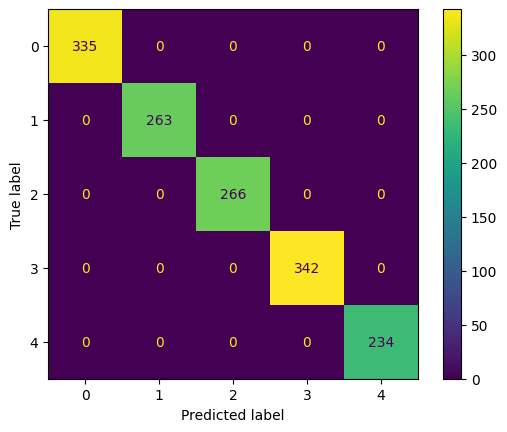

In [214]:
##Use Decision Tree
from sklearn.tree import DecisionTreeClassifier
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=20,
    stop_words="english",
    max_features = 1000
)
tfidf = tfidf_vectorizer.fit_transform(train['Text'])
tfidf_test = tfidf_vectorizer.fit_transform(test['Text'])
def build_dt(X,y,max_depth=None, max_leaf_nodes = None, ccp=0):
    clf=DecisionTreeClassifier(random_state=0,max_depth=max_depth,max_leaf_nodes=max_leaf_nodes,ccp_alpha=ccp)
    return clf.fit(X,y)
clf1 = build_dt(tfidf,train.Category)
print('acc = ' , accuracy_score(clf1.predict(tfidf),train.Category))
y_pred = (clf1.fit(tfidf,train.Category).predict(tfidf))
ConfusionMatrixDisplay(confusion_matrix(y_pred,list(train.Category))).plot()
plt.show()
yp = (clf1.predict(tfidf_test))
test['Category'] = yp
test[['ArticleId','Category']].to_csv(path+'/Solution_clf.csv',index=False)

In [215]:
##Check accuracy by strength of train set splitting
for i in np.arange(1,11,2)*0.1:
    model = build_dt(*sklearn.utils.shuffle(tfidf,train.Category,random_state =1 ,n_samples=int(1440*i)))
    
    l = ([model.score(tfidf,train.Category),(i)])
    print(" acc, split" , l)

 acc, split [0.6555555555555556, 0.1]
 acc, split [0.79375, 0.30000000000000004]
 acc, split [0.8708333333333333, 0.5]
 acc, split [0.9361111111111111, 0.7000000000000001]
 acc, split [0.975, 0.9]


<b> <Center> <Big> TEST SET RESULT





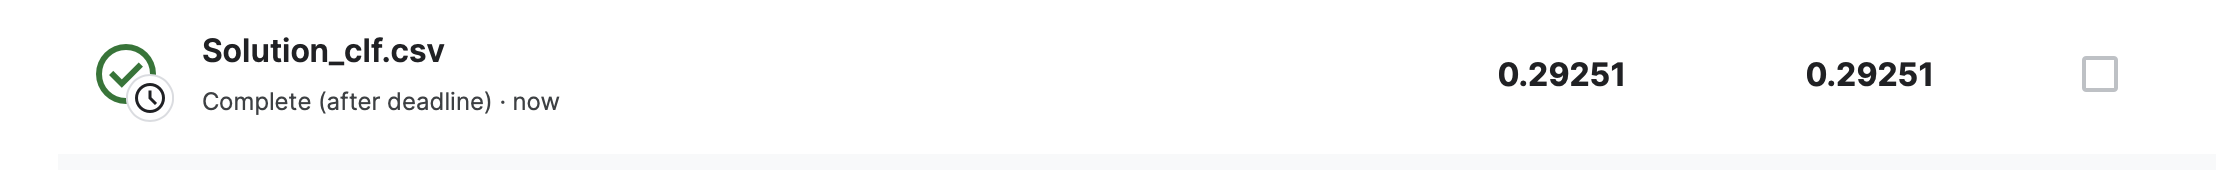

In [267]:
Image("Desktop/Screenshot 2024-05-15 at 4.07.43 AM.png")

<BIG><big>
<big>
 KNN works better than Decision Tree which overfits and uses 90% data to get more than 95% accuracy. The result is a little poor compared to unsupervised learning on the test set. The train set is completely fitted with 100% accuracy

References:
https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [185]:
table.append(['Decision Tree',1.0,0.29])

In [186]:
pd.DataFrame(table[1:],columns=table[0][:]).set_index('Method')

,Train Accuracy,Test Accuracy
Method,,
Hierarchial Clustering,0.88,0.48
KMeans,0.94,0.55
NMF,0.96,0.94
KNN,1.00,0.34
Decision Tree,1.00,0.29
